In [ ]:
!python ~/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/main.py train /u/horlavanasta/MasterProject//DataAndExperiments/Experiments/Experiments-1.5T-3T/NNs_Bayesian/ResNet18/subject_model-ResNet18_preprocessing-linear_task-AD_CN_norm-1_loss-WeightedCrossEntropy_augmTrue --n_splits 1 --split 0  --batch_size 5               

{0: {'name': 'RandomNoise', 'params': {'mean': (-0.03, 0.03), 'std': (0, 0.01)}}, 1: {'name': 'RandomBiasField', 'params': {'coefficients': (0, 0.2), 'order': 1}}, 2: {'name': 'RandomGamma', 'params': {'log_gamma': (-0.15, 0.15)}}, 3: {'name': 'RandomAffine', 'params': {'degrees': (-4, 4), 'scales': (1.0, 1.0), 'isotropic': True, 'default_pad_value': 'mean'}}}


In [1]:
def available_scans(source_dir, ext=".pt"):
    import os
    subject_ids=[]
    for (dirpath, dirnames, filenames) in os.walk(source_dir):
        for f in filenames:
            if f.endswith(ext):
                subject_ids.append(f)
    return subject_ids

In [3]:
scans=available_scans("/u/horlavanasta/MasterProject/DataAndExperiments/Data/CAPS/", ext=".pt")
len(scans)

983

In [6]:
import os
folders=[]
for f in os.scandir("/u/horlavanasta/MasterProject/DataAndExperiments/Data/CAPS_pt/subjects/"):
    if 'sub-' in f.path:
        pass
    folders.append(f.path)
print(len(folders))

983


In [ ]:
for f in folders:
    !echo $f
    !python ~/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/main.py classify ~/MasterProject/ADNI_data/CAPSPreprocessedT1linear ~/MasterProject/ADNI_data/DataPrep/labels_new/test $f test

In [ ]:
f="/u/horlavanasta/MasterProject/NNs_new/subject_model-Conv5_FC3_preprocessing-linear_task-AD_CN_norm-1_augmTrue"
!python ~/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/main.py classify ~/MasterProject/ADNI_data/CAPSPreprocessedT1linear ~/MasterProject/ADNI_data/DataPrep/labels_new/test $f test

In [ ]:
import pathlib
import pandas as pd
import os
progress_list=[]
folders=[]
for f in os.scandir("/u/horlavanasta/MasterProject/NNs_new"):
    if 'subject_model' in f.path and f.path not in progress_list:
        
        folders.append(f.path)
        
for f in folders:
    !echo $f
    !python ~/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/main.py classify ~/MasterProject/ADNI_data/CAPSPreprocessedT1linear ~/MasterProject/ADNI_data/DataPrep/labels_new/test $f test --selection_metrics balanced_accuracy loss last_checkpoint


In [1]:
MS='1.5T-3T'
for NETWORK in ["ResNet18"]:
        
    CAPS_DIR="/u/horlavanasta/MasterProject/DataAndExperiments/Data/CAPS"
    TSV_PATH='/u/horlavanasta/MasterProject/DataAndExperiments/Experiments/Experiments-'+MS+'/labels/test'
    OUTPUT_DIR="/u/horlavanasta/MasterProject//DataAndExperiments/Experiments/Experiments-"+MS+"/NNs_Bayesian/"+NETWORK
    POSTFIX="test_"+MS
    
    folders=[]
    for f in os.scandir(OUTPUT_DIR):
        if 'subject_model' in f.path:

            folders.append(f.path)
    for f in folders[:1]:
        !echo $f
    # Run clinicaaddl
        !python /u/horlavanasta/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/main.py classify $CAPS_DIR $TSV_PATH $f $POSTFIX --selection_metrics balanced_accuracy loss last_checkpoint --bayesian True --nbr_bayesian_iter 5

/u/horlavanasta/MasterProject//DataAndExperiments/Experiments/Experiments-1.5T-3T/NNs_Bayesian/ResNet18/subject_model-ResNet18_preprocessing-linear_task-AD_CN_norm-1_loss-WeightedCrossEntropy_augmFalse


In [ ]:
MS='1.5T-3T'
for NETWORK in ["ResNet18", "SEResNet18", "ResNet18Expanded", "SEResNet18Expanded", "Conv5_FC3"]:
        
    CAPS_DIR="/u/horlavanasta/MasterProject/DataAndExperiments/Data/CAPS"
    TSV_PATH='/u/horlavanasta/MasterProject/DataAndExperiments/Experiments/Experiments-'+MS+'/labels/test'
    OUTPUT_DIR="/u/horlavanasta/MasterProject//DataAndExperiments/Experiments/Experiments-"+MS+"/NNs/"+NETWORK
    POSTFIX="test_"+MS
    
    folders=[]
    for f in os.scandir(OUTPUT_DIR):
        if 'subject_model' in f.path:

            folders.append(f.path)
    for f in folders:
        !echo $f
    # Run clinicaaddl
        !python /u/horlavanasta/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/main.py classify $CAPS_DIR $TSV_PATH $f $POSTFIX --selection_metrics balanced_accuracy loss last_checkpoint

In [ ]:
MS_main='1.5T'
for NETWORK in ["ResNet18", "SEResNet18", "ResNet18Expanded", "SEResNet18Expanded", "Conv5_FC3"]:
        
    CAPS_DIR="/u/horlavanasta/MasterProject/DataAndExperiments/Data/CAPS"
    OUTPUT_DIR="/u/horlavanasta/MasterProject//DataAndExperiments/Experiments/Experiments-"+MS_main+"/NNs/"+NETWORK
    
    folders=[]
    for f in os.scandir(OUTPUT_DIR):
        if 'subject_model' in f.path:

            folders.append(f.path)
            
    
    
    for f in folders:
        MS='1.5T'
        TSV_PATH='/u/horlavanasta/MasterProject/DataAndExperiments/Experiments/Experiments-'+MS+'/labels/test'
        POSTFIX="test_"+MS
        !echo $f
        !python /u/horlavanasta/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/main.py classify $CAPS_DIR $TSV_PATH $f $POSTFIX --selection_metrics balanced_accuracy loss last_checkpoint
        
        MS='3T'
        TSV_PATH='/u/horlavanasta/MasterProject/DataAndExperiments/Experiments/Experiments-'+MS+'/labels/'
        POSTFIX="test_"+MS
        !echo $f
        # Run clinicaaddl
        !python /u/horlavanasta/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/main.py classify $CAPS_DIR $TSV_PATH $f $POSTFIX --selection_metrics balanced_accuracy loss last_checkpoint --baseline False

In [ ]:
MS_main='3T'
for NETWORK in ["ResNet18Expanded", "SEResNet18Expanded", "Conv5_FC3"]:
        
    CAPS_DIR="/u/horlavanasta/MasterProject/DataAndExperiments/Data/CAPS"
    OUTPUT_DIR="/u/horlavanasta/MasterProject//DataAndExperiments/Experiments/Experiments-"+MS_main+"/NNs/"+NETWORK
    
    folders=[]
    for f in os.scandir(OUTPUT_DIR):
        if 'subject_model' in f.path:

            folders.append(f.path)
            
    
    
    for f in folders:
        MS='3T'
        TSV_PATH='/u/horlavanasta/MasterProject/DataAndExperiments/Experiments/Experiments-'+MS+'/labels/test'
        POSTFIX="test_"+MS
        !echo $f
        !python /u/horlavanasta/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/main.py classify $CAPS_DIR $TSV_PATH $f $POSTFIX --selection_metrics balanced_accuracy loss last_checkpoint
        
        MS='1.5T'
        TSV_PATH='/u/horlavanasta/MasterProject/DataAndExperiments/Experiments/Experiments-'+MS+'/labels/'
        POSTFIX="test_"+MS
        !echo $f
        # Run clinicaaddl
        !python /u/horlavanasta/MasterProject/Code/ClinicaTools/AD-DL/clinicaaddl/clinicaaddl/main.py classify $CAPS_DIR $TSV_PATH $f $POSTFIX --selection_metrics balanced_accuracy loss last_checkpoint --baseline False

In [ ]:
len(folders)

In [ ]:
folders=[]
for f in os.scandir("/u/horlavanasta/MasterProject/NNs_new"):
    if 'subject_model' in f.path:
        folders.append(f.path)

len(folders)

In [ ]:
progress_list=["/u/horlavanasta/MasterProject/NNs_new/subject_model-SEResNet18_preprocessing-linear_task-AD_CN_norm-1_loss-default_augmTrue"]

In [37]:
readable_params=['model', 'data_augmentation', 'batch_size', 'learning_rate', "loss", 'training MS']
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import json
import numpy as np
from matplotlib import cm

def plot_loss_with_results(params, results, history, saved_file_path=None):
    num_figures=len(results.keys())
    fig, axes = plt.subplots(2, num_figures, figsize=(int(12*num_figures), 18))
    str_suptitle="Params: "
    
    for i, line in enumerate(readable_params):
        str_suptitle+=line+': '+str(params[line])+"; "
        
    for k,mode in enumerate(results.keys()):
        plot_bar_plots(axes[0][k], results[mode], mode)
        
    plot_history(axes[1][0], history, mode='loss')
    plot_history(axes[1][1], history, mode='balanced_accuracy')

    plt.suptitle(str_suptitle)
#     plt.tight_layout()

#     plt.show()
    if saved_file_path is not None:
        plt.savefig(saved_file_path)
    else:
        plt.show()
        
    plt.close()
        
def plot_history(ax, history, mode):
    def find_best(arr, ismin=True):
        arr=np.array(arr)
        if ismin:
            best_loss_idx_train=np.where(arr == np.amin(arr))[0][0]
        else:
            best_loss_idx_train=np.where(arr == np.amax(arr))[0][0]
        return best_loss_idx_train, arr[best_loss_idx_train]
            
    ax.plot(history["epoch"], history[mode+"_train"], 'black', lw=1, label='train '+mode)
    ax.plot(history["epoch"], history[mode+"_valid"], 'red', lw=1, label='validation '+mode)
    
    idx, val=find_best(history[mode+"_valid"], mode=='loss')
    ax.plot(idx, val,'o', color='black')
    
#     ax.legend()
    ax.legend(bbox_to_anchor=(0.5, -0.15), loc='lower center',
         ncol=2, fontsize ='large')
    
    if mode=='loss':
        ax.set_ylim(bottom=-0.001, top=0.5)
    if mode=='balanced_accuracy':
        ax.set_ylim(bottom=-0.001, top=1.1)
    ax.set_title(mode)
    
def plot_bar_plots(ax, results, mode):
    
    def autolabel(ax, rects):
        for rect in rects:

            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                    '%.3f' % (height),
                    ha='center', va='bottom')
        
    def reshape_results(results):
        metrics={}
        for key in results[list(results.keys())[0]].keys():
            metrics[key]=[]
        for mode in results.keys():
            for metric in results[mode].keys():
                metrics[metric].append(results[mode][metric][0])
        return metrics
    
    ax.set_ylim(bottom=-0.001, top=1.1)
    results_transposed = reshape_results(results)
    N=len(results.keys())
    
    ind = np.arange(N)
    width = 0.2       
    width_ratio=0.9
#     ax.set_prop_cycle('color', Pastel1_4.mpl_colors)
    ax.set_prop_cycle('color', cm.get_cmap('Paired').colors)

    
    for i, key in enumerate(results_transposed.keys()):
        autolabel(ax, ax.bar(ind+width*i, results_transposed[key] , width*width_ratio, label=key.capitalize(), edgecolor='dimgrey'))
    
    xstips_position=ind + width

    xsticklabels=[disease_type for disease_type in results.keys()]
    ax.set_xticklabels(xsticklabels)
    ax.set_xticks(xstips_position)
    ax.legend(bbox_to_anchor=(0.5, -0.15), loc='lower center',
         ncol=3, fontsize ='large')
    ax.set_title("Model from: "+ mode)

In [45]:
import pathlib
import pandas as pd
import os
progress_list=[]
folders=[]
MS_main_list=['1.5T-3T']


# modes=['train', 'validation', 'test']
# modes=['test']
for MS in MS_main_list:
    model_types=["SEResNet18", "ResNet18","Conv5_FC3", "SEResNet18Expanded","ResNet18Expanded"]
    

    reported_best_accuracies={}

    for model_type in model_types:
        reported_best_accuracies[model_type]={"max_value":0,"mode":"", "results":{}, "params":{}, "history":{},"model_name":{} }

    results_folder='/u/horlavanasta/MasterProject/Code/ClinicaTools/AD-DL/results/Experiments/Experiments-'+MS
    
    for NETWORK in ["ResNet18", "SEResNet18", "ResNet18Expanded", "SEResNet18Expanded", "Conv5_FC3"]:
        
        OUTPUT_DIR="/u/horlavanasta/MasterProject//DataAndExperiments/Experiments/Experiments-"+MS+"/NNs/"+NETWORK
    
        folders=[]
        for f in os.scandir(OUTPUT_DIR):
            if 'subject_model' in f.path:
                folders.append(f.path)
                
        if ".ipynb_checkpoints" in folders:
                    folders.remove(".ipynb_checkpoints")
            
        for f in folders[:]:
            currentDirectory = pathlib.Path(f)
        #     print("currentDirectory")

            # Search for 'fold-*' pattern
            currentPattern = "fold-*"
            path_params=os.path.join(currentDirectory,"commandline_train.json")

            with open(path_params, "r") as f:
                    params = json.load(f)

            # loop depending the number of folds found in the model folder
            for fold_dir in currentDirectory.glob(currentPattern):
                fold = int(str(fold_dir).split("-")[-1])
                results={}

                selection_metrics=[]
                performance_dir = os.path.join(currentDirectory, 'fold-%i' % fold, 'cnn_classification')
                for f in os.scandir(performance_dir):
                    selection_metrics.append(os.path.basename(os.path.normpath(f.path)))
                    
                if ".ipynb_checkpoints" in selection_metrics:
                    selection_metrics.remove(".ipynb_checkpoints")

                for selection_metric in selection_metrics:
                    results[selection_metric]={}
                    history = pd.read_csv(os.path.join(currentDirectory, 'fold-%i' % fold, 'training.tsv'), sep='\t')
                    if selection_metric=="last_checkpoint":
                        modes=['test_1.5T-3T']
                    else:
                        modes=['train', 'validation', 'test_1.5T-3T'] 

                    for mode in modes:

                        test_diagnosis_path=os.path.join(performance_dir, selection_metric,'%s_image_level_metrics.tsv' % (mode))
                        test_diagnosis_df = pd.read_csv(test_diagnosis_path, sep='\t')
                        results[selection_metric][mode]=test_diagnosis_df[["sensitivity", 'specificity', 'balanced_accuracy', 'accuracy']]

                folder_type='barplots_with_loss'
                

                preprocessing=params["preprocessing"]

                augmentations_presense='augmentations' if params['data_augmentation'] else "no_augmentations"
                network_type=params['model']
                if "loss" not in params.keys():
                    params['loss']='default'

                loss=params['loss']
                
                params['training MS']=MS

                name=os.path.basename(os.path.normpath(currentDirectory))
                folder_type='barplots_with_loss'
                path=os.path.join(results_folder, folder_type, preprocessing, network_type, augmentations_presense, loss)
                os.makedirs(path, exist_ok=True)
                file_name='barplots_'+name+'.png'
                plot_loss_with_results(params, results, history, os.path.join(path, file_name))
                    
                for mode in results.keys():
                    if results[mode]['test_1.5T-3T']["balanced_accuracy"][0]>reported_best_accuracies[network_type]["max_value"]:
                        reported_best_accuracies[network_type]["max_value"]=results[mode]['test_1.5T-3T']["balanced_accuracy"][0]
                        reported_best_accuracies[network_type]["mode"]=mode
                        reported_best_accuracies[network_type]["results"]=results
                        reported_best_accuracies[network_type]["params"]=params
                        reported_best_accuracies[network_type]["history"]=history
                        reported_best_accuracies[network_type]["model_name"]=name 


        best_results_path=os.path.join(results_folder, "best_results")

        os.makedirs(best_results_path, exist_ok=True)

    for network_type in model_types:   
#     print(reported_best_accuracies[network_type]["params"])
        if reported_best_accuracies[network_type]["max_value"]>0.0:
            print(network_type, reported_best_accuracies[network_type]["params"]["loss"],  reported_best_accuracies[network_type]["mode"], reported_best_accuracies[network_type]["max_value"])

            filepath=os.path.join(best_results_path, reported_best_accuracies[network_type]["model_name"]) 
            plot_loss_with_results(reported_best_accuracies[network_type]["params"], reported_best_accuracies[network_type]["results"], reported_best_accuracies[network_type]["history"], filepath)




SEResNet18 WeightedCrossEntropy last_checkpoint 0.8219832735961767
ResNet18 WeightedCrossEntropy best_loss 0.8405017921146953
Conv5_FC3 WeightedCrossEntropy last_checkpoint 0.8518518518518519
SEResNet18Expanded WeightedCrossEntropy best_loss 0.8960573476702509
ResNet18Expanded WeightedCrossEntropy last_checkpoint 0.7873357228195939


In [42]:
import pathlib
import pandas as pd
import os
progress_list=[]
folders=[]
MS_main_list=['1.5T', '3T']


# modes=['train', 'validation', 'test']
# modes=['test']
for MS in MS_main_list:
    model_types=["SEResNet18", "ResNet18","Conv5_FC3", "SEResNet18Expanded","ResNet18Expanded"]
    MS_list=['1.5T','3T'] if MS=='1.5T' else ['3T', '1.5T'] 

    reported_best_accuracies={}

    
    for ms_el in MS_list:
        reported_best_accuracies[ms_el]={}
        for model_type in model_types:
            reported_best_accuracies[ms_el][model_type]={"max_value":0,"mode":"", "results":{}, "params":{}, "history":{},"model_name":{} }

    results_folder='/u/horlavanasta/MasterProject/Code/ClinicaTools/AD-DL/results/Experiments/Experiments-'+MS

    
    for NETWORK in ["ResNet18", "SEResNet18", "ResNet18Expanded", "SEResNet18Expanded", "Conv5_FC3"]:
        
        OUTPUT_DIR="/u/horlavanasta/MasterProject//DataAndExperiments/Experiments/Experiments-"+MS+"/NNs/"+NETWORK
    
        folders=[]
        for f in os.scandir(OUTPUT_DIR):
            if 'subject_model' in f.path:
                folders.append(f.path)
                
        if ".ipynb_checkpoints" in folders:
                    folders.remove(".ipynb_checkpoints")
            
        for f in folders[:]:
            currentDirectory = pathlib.Path(f)
        #     print("currentDirectory")

            # Search for 'fold-*' pattern
            currentPattern = "fold-*"
            path_params=os.path.join(currentDirectory,"commandline_train.json")

            with open(path_params, "r") as f:
                    params = json.load(f)

            # loop depending the number of folds found in the model folder
            for fold_dir in currentDirectory.glob(currentPattern):
                fold = int(str(fold_dir).split("-")[-1])
                results={}

                selection_metrics=[]
                performance_dir = os.path.join(currentDirectory, 'fold-%i' % fold, 'cnn_classification')
                for f in os.scandir(performance_dir):
                    selection_metrics.append(os.path.basename(os.path.normpath(f.path)))
                    
                if ".ipynb_checkpoints" in selection_metrics:
                    selection_metrics.remove(".ipynb_checkpoints")

                for selection_metric in selection_metrics:
                    results[selection_metric]={}
                    history = pd.read_csv(os.path.join(currentDirectory, 'fold-%i' % fold, 'training.tsv'), sep='\t')
                    if selection_metric=="last_checkpoint":
                        modes=['test_'+ms_el for ms_el in MS_list]
                    else:
                        modes=['train', 'validation'] 
                        for ms_el in MS_list:
                            modes.append('test_'+ms_el)

                    for mode in modes:

                        test_diagnosis_path=os.path.join(performance_dir, selection_metric,'%s_image_level_metrics.tsv' % (mode))
                        test_diagnosis_df = pd.read_csv(test_diagnosis_path, sep='\t')
                        results[selection_metric][mode]=test_diagnosis_df[["sensitivity", 'specificity', 'balanced_accuracy', 'accuracy']]

                folder_type='barplots_with_loss'
                

                preprocessing=params["preprocessing"]

                augmentations_presense='augmentations' if params['data_augmentation'] else "no_augmentations"
                network_type=params['model']
                if "loss" not in params.keys():
                    params['loss']='default'

                loss=params['loss']
                
                params['training MS']=MS

                name=os.path.basename(os.path.normpath(currentDirectory))
                folder_type='barplots_with_loss'
                path=os.path.join(results_folder, folder_type, preprocessing, network_type, augmentations_presense, loss)
                os.makedirs(path, exist_ok=True)
                file_name='barplots_'+name+'.png'
                plot_loss_with_results(params, results, history, os.path.join(path, file_name))
                    
                for mode in results.keys():
                    for ms_el in MS_list:
                        if results[mode]["test_"+ms_el]["balanced_accuracy"][0]>reported_best_accuracies[ms_el][network_type]["max_value"]:
                            reported_best_accuracies[ms_el][network_type]["max_value"]=results[mode]["test_"+MS]["balanced_accuracy"][0]
                            reported_best_accuracies[ms_el][network_type]["mode"]=mode
                            reported_best_accuracies[ms_el][network_type]["results"]=results
                            reported_best_accuracies[ms_el][network_type]["params"]=params
                            reported_best_accuracies[ms_el][network_type]["history"]=history
                            reported_best_accuracies[ms_el][network_type]["model_name"]=name 


    best_results_path=os.path.join(results_folder, "best_results")

    os.makedirs(best_results_path, exist_ok=True)
    for network_type in model_types: 
        for ms_el in MS_list:
          
    #     print(reported_best_accuracies[network_type]["params"])
            if reported_best_accuracies[ms_el][network_type]["max_value"]>0.0:
                print(network_type, ms_el, reported_best_accuracies[ms_el][network_type]["params"]["loss"],  reported_best_accuracies[ms_el][network_type]["mode"], reported_best_accuracies[ms_el][network_type]["max_value"])
                ms_el_name = '1_5T' if ms_el=='1.5T' else ms_el
                filepath=os.path.join(best_results_path, ms_el_name+'_'+reported_best_accuracies[ms_el][network_type]["model_name"]) 
                plot_loss_with_results(reported_best_accuracies[ms_el][network_type]["params"], reported_best_accuracies[ms_el][network_type]["results"], reported_best_accuracies[ms_el][network_type]["history"], filepath)




SEResNet18 1.5T WeightedCrossEntropy best_balanced_accuracy 0.8791866028708134
SEResNet18 3T default last_checkpoint 0.7739234449760766
ResNet18 1.5T WeightedCrossEntropy best_balanced_accuracy 0.8791866028708134
ResNet18 3T WeightedCrossEntropy best_loss 0.8002392344497608
Conv5_FC3 1.5T WeightedCrossEntropy last_checkpoint 0.8791866028708134
Conv5_FC3 3T WeightedCrossEntropy best_loss 0.8229665071770335
SEResNet18Expanded 1.5T default last_checkpoint 0.8791866028708134
SEResNet18Expanded 3T WeightedCrossEntropy best_loss 0.8229665071770335
ResNet18Expanded 1.5T WeightedCrossEntropy last_checkpoint 0.8373205741626795
ResNet18Expanded 3T WeightedCrossEntropy last_checkpoint 0.8373205741626795
SEResNet18 3T default last_checkpoint 0.8125
SEResNet18 1.5T WeightedCrossEntropy last_checkpoint 0.75
ResNet18 3T default best_balanced_accuracy 0.8125
ResNet18 1.5T WeightedCrossEntropy last_checkpoint 0.75
Conv5_FC3 3T WeightedCrossEntropy best_loss 0.6875
Conv5_FC3 1.5T WeightedCrossEntropy be

KeyboardInterrupt: 

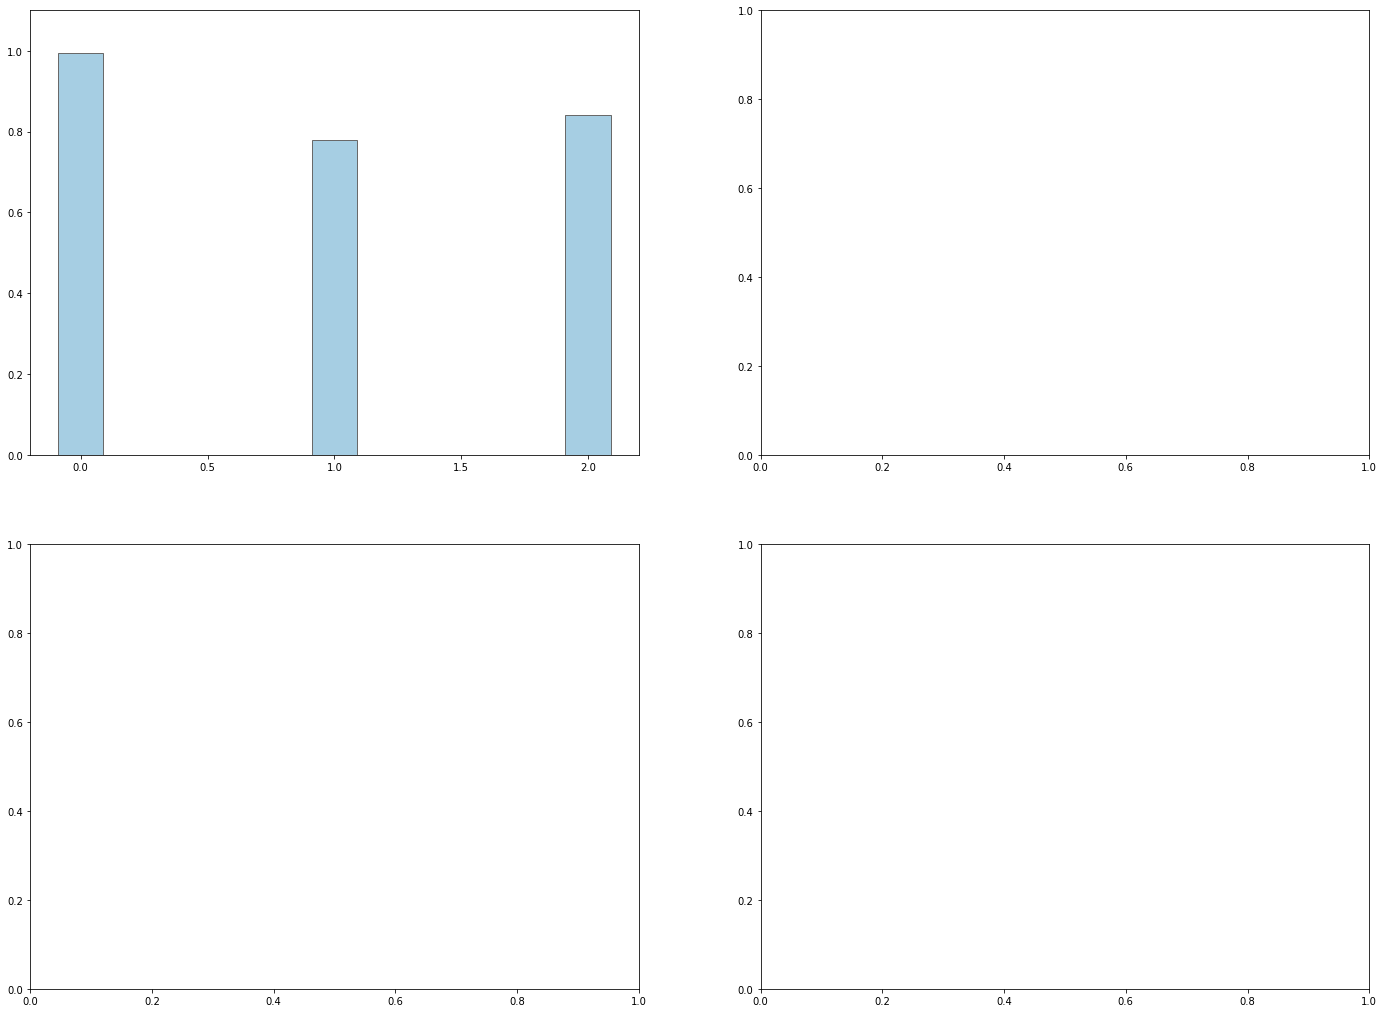

In [28]:
import pathlib
import pandas as pd
import os
progress_list=['/u/horlavanasta/MasterProject/NNs_new/subject_model-SEResNet18_preprocessing-linear_task-AD_CN_norm-1_loss-default_augmTrue']
folders=[]
for f in os.scandir("/u/horlavanasta/MasterProject/NNs_new"):
    if 'subject_model' in f.path and f.path not in progress_list:
        folders.append(f.path)

# modes=['train', 'validation', 'test']
# modes=['test']

model_types=["SEResNet18", "ResNet18","Conv5_FC3", "SEResNet18Expanded","ResNet18Expanded"]
reported_best_accuracies={}
for model_type in model_types:
    reported_best_accuracies[model_type]={"max_value":0,"mode":"", "results":{}, "params":{}, "history":{},"model_name":{} }

results_folder='/u/horlavanasta/MasterProject/Code/ClinicaTools/AD-DL/results/test-0.1/'
for f in folders[:]:
    currentDirectory = pathlib.Path(f)
#     print("currentDirectory")

    # Search for 'fold-*' pattern
    currentPattern = "fold-*"
    path_params=os.path.join(currentDirectory,"commandline_train.json")
    
    with open(path_params, "r") as f:
            params = json.load(f)
            
    # loop depending the number of folds found in the model folder
    for fold_dir in currentDirectory.glob(currentPattern):
        fold = int(str(fold_dir).split("-")[-1])
        results={}
        
        selection_metrics=[]
        performance_dir = os.path.join(currentDirectory, 'fold-%i' % fold, 'cnn_classification')
        for f in os.scandir(performance_dir):
            selection_metrics.append(os.path.basename(os.path.normpath(f.path)))
        if ".ipynb_checkpoints" in selection_metrics:
            selection_metrics.remove(".ipynb_checkpoints")
        for selection_metric in selection_metrics:
            results[selection_metric]={}
            history = pd.read_csv(os.path.join(currentDirectory, 'fold-%i' % fold, 'training.tsv'), sep='\t')
            if selection_metric=="last_checkpoint":
                modes=['test']
            else:
                modes=['train', 'validation', 'test']
                
            for mode in modes:
                
                test_diagnosis_path=os.path.join(performance_dir, selection_metric,'%s_image_level_metrics.tsv' % (mode))
                test_diagnosis_df = pd.read_csv(test_diagnosis_path, sep='\t')
                results[selection_metric][mode]=test_diagnosis_df[["sensitivity", 'specificity', 'balanced_accuracy', 'accuracy']]
        
        folder_types=['barplots_with_loss']
        if len(selection_metrics)==3:
            folder_types.append('barplots_with_loss_with_last_epoch')
        
        preprocessing=params["preprocessing"]

        augmentations_presense='augmentations' if params['data_augmentation'] else "no_augmentations"
        network_type=params['model']
        if "loss" not in params.keys():
            params['loss']='default'

        loss=params['loss']
        
        name=os.path.basename(os.path.normpath(currentDirectory))
        for folder_type in folder_types:
            path=os.path.join(results_folder, folder_type, preprocessing, network_type, augmentations_presense, loss)
            os.makedirs(path, exist_ok=True)
            file_name='barplots_'+name+'.png'

            plot_loss_with_results(params, results, history, os.path.join(path, file_name))
        for mode in results.keys():
            if results[mode]["test"]["balanced_accuracy"][0]>reported_best_accuracies[network_type]["max_value"]:
                reported_best_accuracies[network_type]["max_value"]=results[mode]["test"]["balanced_accuracy"][0]
                reported_best_accuracies[network_type]["mode"]=mode
                reported_best_accuracies[network_type]["results"]=results
                reported_best_accuracies[network_type]["params"]=params
                reported_best_accuracies[network_type]["history"]=history
                reported_best_accuracies[network_type]["model_name"]=name 
                
            
best_results_path=os.path.join(results_folder, "best_results")

os.makedirs(best_results_path, exist_ok=True)
for network_type in model_types:
    
#     print(reported_best_accuracies[network_type]["params"])
    if reported_best_accuracies[network_type]["max_value"]>0.0:
        print(network_type, reported_best_accuracies[network_type]["params"]["loss"],  reported_best_accuracies[network_type]["mode"], reported_best_accuracies[network_type]["max_value"])

        filepath=os.path.join(best_results_path, reported_best_accuracies[network_type]["model_name"]) 
        plot_loss_with_results(reported_best_accuracies[network_type]["params"], reported_best_accuracies[network_type]["results"], reported_best_accuracies[network_type]["history"], filepath)


        
        
#     print("__________________________________________________________________________________")
            
    